In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Lecture 1
import pickle

import matplotlib.pyplot as plt

# Other
import numpy as np
import numpy.random as npr
import pandas as pd

# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier
from sklearn import datasets
from sklearn.datasets import (
    fetch_20newsgroups,
    load_digits,
    make_blobs,
    make_hastie_10_2,
)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    cross_val_predict,
    train_test_split,
)
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.tree import DecisionTreeClassifier
import IPython

from IPython.display import HTML, display


%matplotlib inline

pd.set_option("display.max_colwidth", 200)

import seaborn as sns
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# Lecture 1: Classification evaluation metrics, class imbalance

## 1. Accuracy score VS Confusion matrix
### 1). Accuracy score:
When there is class imbalance, the `DummyClassifier` can still give us a high accuracy, but it is a terrible model. Accuracy is misleading when we have class imbalance.
### 2). Confusion matrix:
- A confusion matrix is a summary of prediction results on a classification problem.   
- Confusion matrix can be used when there is class imbalance. Confusion matrix, precision, recall give us a better understanding of the kinds of errors the model is making and are useful even when there is no class imbalance.

|   X   | predict negative | predict positive |
|------|----------|-------|
| negative example | True negative (TN) | False positive (FP)|
| positive example | False negative (FN) | True positive (TP) |


<center>
<img src= "img/evaluation_metrics.png" width="500" align="center"/>
</center>



> what you consider "positive" (fraud in our case) is important when calculating precision, recall, and f1-score. 

- **Precision**
> Among the positive examples you identified, how many were actually positive?

- Useful when False Positives are probably worse than False Negatives for a problem.     
- such as identify spam, we want to be conservative and bias the model towards predicting "positive".



$$ precision = \frac{TP}{TP+FP}$$


- **Recall**. 
> Among all positive examples, how many did you identify?

- Useful when False Negatives are probably worse than False Positives for a problem. 
- such as identify cancer. high recall is more important than high precision because High recall means less false negatives.

$$ recall = \frac{TP}{TP+FN} = \frac{TP}{\#positives} $$

- **F1-score**
    - F1-score combines precision and recall to give one score, which could be used in hyperparameter optimization, for instance. 
    - F1-score is a harmonic mean of precision and recall. 


$$ f1 = 2 \times \frac{ precision \times recall}{precision + recall}$$



<br>

### There is no pattern between accuracy and recall and precision.


Method A - higher accuracy but lower precision

|Actual| Negative | Positive
|--| -------- |:-------------:|
|Negative| 90      | 5|
|Positive| 5      | 0|

Method B - lower accuracy but higher precision

|Actual | Negative | Positive
|-- | -------- |:-------------:|
|Negative | 80      | 15|
| Positive| 0      | 5|



- Method A accuracy: 90/100
- Method B accuracy: 85/100
- Method A precision: 0
- Method B precision: 0.25



In [2]:
cc_df = pd.read_csv("data/creditcard.csv", encoding="latin-1")
train_df, test_df = train_test_split(cc_df, test_size=0.3, random_state=111)

X_train_big, y_train_big = train_df.drop(columns=["Class"]), train_df["Class"]
X_test, y_test = test_df.drop(columns=["Class"]), test_df["Class"]


X_train, X_valid, y_train, y_valid = train_test_split(X_train_big, 
                                                      y_train_big, 
                                                      test_size=0.3, 
                                                      random_state=123)

In [3]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
pd.DataFrame(cross_validate(pipe_lr, X_train, y_train, return_train_score=True)).mean()

fit_time       0.616567
score_time     0.010932
test_score     0.999176
train_score    0.999249
dtype: float64

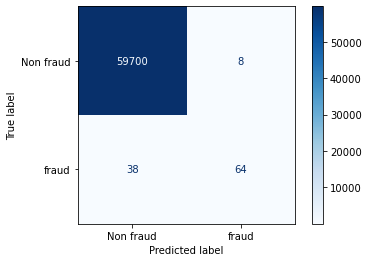

In [4]:
pipe_lr.fit(X_train, y_train)
disp = plot_confusion_matrix(
    pipe_lr,
    X_valid,
    y_valid,
    display_labels=["Non fraud", "fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
);

disp

In [5]:
from sklearn.metrics import confusion_matrix

predictions = pipe_lr.predict(X_valid)

TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()

print("Confusion matrix for fraud data set")
print(disp.confusion_matrix)

Confusion matrix for fraud data set
[[59700     8]
 [   38    64]]


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
data = {}

# Calculate evaluation metrics by ourselves
data["accuracy"] = [(TP + TN) / (TN + FP + FN + TP)]
data["error"] = [(FP + FN) / (TN + FP + FN + TP)]
precision = TP / (TP + FP)
data["precision"] = [precision]
recall = TP / (TP + FN)
data["recall"] = [recall]
data["f1 score"] = [(2 * precision * recall) / (precision + recall)]

# use scikit-learn to calculate these metrics
data["accuracy"].append(accuracy_score(y_valid, pipe_lr.predict(X_valid)))
data["error"].append(1 - accuracy_score(y_valid, pipe_lr.predict(X_valid)))
data["precision"].append(precision_score(y_valid, pipe_lr.predict(X_valid), zero_division=1))
data["recall"].append(recall_score(y_valid, pipe_lr.predict(X_valid)))
data["f1 score"].append(f1_score(y_valid, pipe_lr.predict(X_valid)))
df = pd.DataFrame(data)
df

,accuracy,error,precision,recall,f1 score
0,0.999231,0.000769,0.888889,0.627451,0.735632
1,0.999231,0.000769,0.888889,0.627451,0.735632


## 2. Classification report


### Macro average vs weighted average
> when #positive = #negative, the two averages are equal

macro average 
- You give equal importance to all classes and average over all classes.  
- For instance, in the example above, recall for non-fraud is 1.0 and fraud is 0.63, and so macro average is 0.81. 
- More relevant in case of multi-class problems.

weighted average    
- Weighted by the number of samples in each class. 
- Divide by the total number of samples. 

Which one is relevant when depends upon whether you think each class should have the same weight or each sample should have the same weight.

In [7]:
y_valid.value_counts()

0    59708
1      102
Name: Class, dtype: int64

In [8]:
from sklearn.metrics import classification_report

y_pred = pipe_lr.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



In [9]:
y_pred = pipe_lr.predict_proba(X_valid)[:, 1] > 0.50
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



In [10]:
y_pred = pipe_lr.predict_proba(X_valid)[:, 1] > .30
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.82      0.67      0.74       102

    accuracy                           1.00     59810
   macro avg       0.91      0.83      0.87     59810
weighted avg       1.00      1.00      1.00     59810



## 3. Precision-recall curve (NOT monotonic) - `AP`

> There is a trade-off between precision and recall.   
> if you identify more things as positive, recall is going to increase but there are likely to be more false positives.

- Recall that precision = TP/TP+FP and recall = TP/# positives
- We said earlier that predict returns 1 when predict_proba's probabilities are above 0.5 for the positive class.
- **Decreasing** the threshold means a **lower bar for predicting fraud**. 
    - recall would either stay the same or go up and precision is likely to go down
    - occasionally, precision may increase if all the new examples after decreasing the threshold are TPs.  
- **Increasing** the threshold means a **higher bar for predicting fraud**. 
    - recall would go down or stay the same but precision is likely to go up 
    - occasionally, precision may go down as the denominator for precision is TP+FP. 
  


<br>

---

#### AP

- **AP**: area under curve, is a score that summarizes the "goodness" of the below plot.
    - Precision refers to precision at a particular decision threshold. For example, if you count any model output less than 0.5 as negative, and greater than 0.5 as positive. But sometimes (especially if your classes are not balanced, or if you want to favor precision over recall or vice versa), you may want to vary this threshold. 

    - Average precision gives you average precision at all such possible thresholds, which is also similar to the area under the precision-recall curve. It is a useful metric to compare how well models are ordering the predictions, without considering any specific decision threshold.
    

- AP and F1
    - F1 score is for a given threshold and measures the quality of `predict`.
    - AP score is a summary across thresholds and measures the quality of `predict_proba`.

In [11]:
thresholds = np.arange(0.0, 1.0, 0.1)
pr_dict = {"threshold":[], "precision":[], "recall":[], "f1 score":[]}
for threshold in thresholds:
    preds = pipe_lr.predict_proba(X_valid)[:,1] > threshold
    pr_dict['threshold'].append(threshold)
    pr_dict['precision'].append(precision_score(y_valid, preds))
    pr_dict['recall'].append(recall_score(y_valid, preds))
    pr_dict['f1 score'].append(f1_score(y_valid, preds))
    
    
pd.DataFrame(pr_dict)

,threshold,precision,recall,f1 score
0,0.0,0.001705,1.000000,0.003405
1,0.1,0.780000,0.764706,0.772277
2,0.2,0.795699,0.725490,0.758974
3,0.3,0.819277,0.666667,0.735135
4,0.4,0.876712,0.627451,0.731429
5,0.5,0.888889,0.627451,0.735632
6,0.6,0.897059,0.598039,0.717647
7,0.7,0.892308,0.568627,0.694611
8,0.8,0.901639,0.539216,0.674847
9,0.9,0.894737,0.500000,0.641509


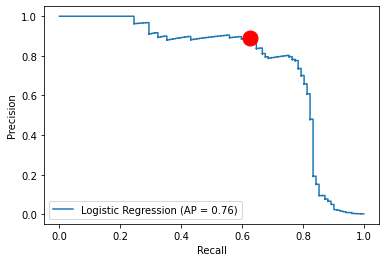

In [12]:
from sklearn.metrics import plot_precision_recall_curve

prc = plot_precision_recall_curve(pipe_lr, X_valid, y_valid, name="Logistic Regression")

plt.plot(
    recall_score(y_valid, pipe_lr.predict(X_valid)),
    precision_score(y_valid, pipe_lr.predict(X_valid)),
    "or",
    markersize=15,
);

## 4. ROC Curve (monotonic) - `AUC`

> Receiver Operating Characteristic Curve

- [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) plots sensitivity (recall) ($\frac{TP}{\#positives}$) against false positive rate ($\frac{FP}{\# negatives }$) 
- Similar to PR curve, it's based on `predict_proba` scores. 
- The diagonal line is what happens if your guesses are random.

<br>


**AP and ROC**

- Unlike the precision-recall curve, here the top-left is the best.
- Unlike the precision-recall curve, this curve is monotonic.
- AUC (Area under the ROC Curve) provides a single meaningful number for the model performance. 
- AUC of 1.0 means perfect classification and AUC of 0.5 means random chance


<br>

---

#### Extra information 

- If the threshold is 1, we always predict "negative".
    - the true positive rate is 0 because there are no true positives
    - the false positive rate is 0 because there are no false positives
    - this is the bottom-left point in the curve
- If the threshold is 0, we always predict "positive".
    - the true positive rate (recall) is 1 because we have identified all positive examples
    - the false positive rate is 1 because we have falsely identified all negatives as positive
    - this is the upper-right point in the curve

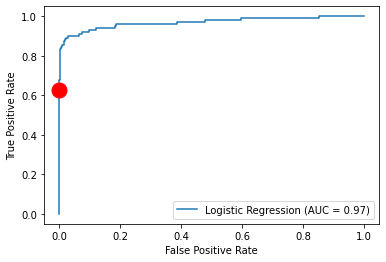

In [13]:
from sklearn.metrics import plot_roc_curve
cm = confusion_matrix(y_valid, pipe_lr.predict(X_valid))

rc = plot_roc_curve(pipe_lr, X_valid, y_valid, name='Logistic Regression');

plt.plot(cm[0,1]/(cm[0].sum()), cm[1,1]/(cm[1].sum()), 'or', markersize=15);

# - The red dot corresponds to the threshold of 0.5, which is used by predict.

> raw value of `AP` and `AUC` 

In [14]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_valid, pipe_lr.predict_proba(X_valid)[:,1])

0.9689508549450464

## 5. all the scores at once

In [15]:
scoring=["accuracy", "f1", "recall", "precision", 'roc_auc', 'average_precision']
pipe = make_pipeline(StandardScaler(), LogisticRegression())
scores = cross_validate(pipe, X_train_big, y_train_big, scoring=scoring)

pd.DataFrame(scores).mean()
# pd.DataFrame(pd.DataFrame(scores).mean()).T

fit_time                  0.802660
score_time                0.073595
test_accuracy             0.999212
test_f1                   0.724369
test_recall               0.610536
test_precision            0.894228
test_roc_auc              0.967438
test_average_precision    0.744030
dtype: float64

## 6. Handling imbalance

Can we change the model itself rather than changing the threshold so that it takes into account the errors that are important to us?

There are two common approaches for this: 
- **Changing the training procedure** 
    - `class_weight`
    - All `sklearn` classifiers have a parameter called `class_weight`.
    - This allows you to specify that one class is more important than another.
    - For example, maybe a false negative is 10x more problematic than a false positive. 
- **Changing the data (optional)**
   - Undersampling
   - Oversampling 
       - Random oversampling
       - SMOTE 

#### 1). `class_weight={1:10}`


Advantages of class_weight method over oversampling methods include:

- it's much faster because it's incorporated in the learning procedure.
- it's easy to use, as all sklearn classifier support it.

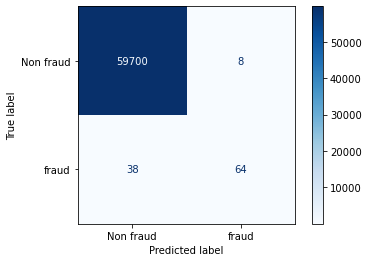

In [16]:
plot_confusion_matrix(pipe_lr, X_valid, y_valid, 
                      display_labels=["Non fraud", "fraud"], 
                      values_format="d", cmap=plt.cm.Blues);

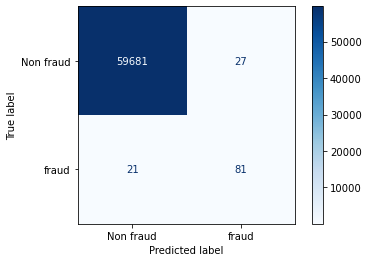

In [17]:
pipe_lr_weight = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, 
                                                                    class_weight={1:10}))
pipe_lr_weight.fit(X_train, y_train)
plot_confusion_matrix(pipe_lr_weight, X_valid, y_valid, display_labels=["Non fraud", "fraud"], values_format="d", cmap=plt.cm.Blues);

#### 2). `class_weight="balanced"`

> **We have reduced false negatives but we have many more false positives now!**

- A useful setting is `class_weight="balanced"`.
- This sets the weights so that the classes are "equal".

<br>

- Changing the class weight will **generally reduce accuracy**.
- The original model was trying to maximize accuracy.
- Now you're telling it to do something different.
- But that can be fine, accuracy isn't the only metric that matters.

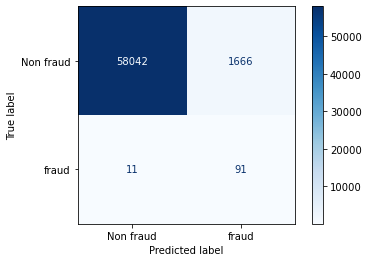

In [18]:
pipe_lr_balanced = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, 
                                                                      class_weight="balanced"))
pipe_lr_balanced.fit(X_train, y_train)
plot_confusion_matrix(pipe_lr_balanced, X_valid, y_valid, display_labels=["Non fraud", "fraud"], values_format="d", cmap=plt.cm.Blues);

> What is "balanced" doing exactly?
``class_weight={1:ratio}``

In [19]:
print(y_train.value_counts())
ratio = np.bincount(y_train)[0]/ np.bincount(y_train)[1]
print("Ratio: ", ratio)

0    139317
1       237
Name: Class, dtype: int64
Ratio:  587.8354430379746


# Lecture 2: Ridge and Regression Evaluation Metrics

## 1. Setup and Pipe

In [122]:
df = pd.read_csv("data/housing-kaggle/train.csv")
train_df, test_df = train_test_split(df, test_size = 0.10, random_state=123)


X_train = train_df.drop(columns=['SalePrice'])
y_train = train_df['SalePrice']

X_test = test_df.drop(columns=['SalePrice'])
y_test = test_df['SalePrice']

In [123]:
drop_features    = ['Id']

ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ex'] # if N/A it will just impute something, per below
[ordering]*len(ordinal_features_reg)

[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex']]

In [124]:
numeric_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
                    'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
                    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                    'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                    'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 
                    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                    'PoolArea', 'MiscVal', 'YrSold']

numeric_looking_columns = X_train.select_dtypes(include=np.number).columns.tolist()

In [125]:
# treat these as categorical features
set(numeric_looking_columns) - set(numeric_features)

# because
train_df['KitchenAbvGr'].unique() # array([1, 2, 3]) 


categorical_features = list(set(X_train.columns) - set(numeric_features) 
                            - set(ordinal_features_reg) - set(drop_features))

In [126]:

numeric_transformer = make_pipeline(SimpleImputer(strategy='median'), 
                                    StandardScaler())
ordinal_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                    OrdinalEncoder(categories=[ordering]
                                                   *len(ordinal_features_reg)))
categorical_transformer = make_pipeline(SimpleImputer(strategy='constant', fill_value="missing"),
                                        OneHotEncoder(handle_unknown='ignore', sparse=False))

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features_reg),
    (categorical_transformer, categorical_features)    
)

#### all new columns

In [145]:
preprocessor.fit(X_train); # Calling fit to examine all the transformers. 



ohe_columns = list(preprocessor.named_transformers_['pipeline-3'].named_steps['onehotencoder'].get_feature_names(categorical_features))
new_columns = numeric_features + ordinal_features_reg + ohe_columns

X_train_enc = pd.DataFrame(preprocessor.transform(X_train), index=X_train.index, columns=new_columns)
X_train_enc.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageType_missing,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed
302,2.312501,0.381428,0.663680,-0.512408,0.993969,0.840492,0.269972,-0.961498,-0.287191,2.197106,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
767,0.260890,0.248457,-0.054669,1.285467,-1.026793,0.016525,-0.573129,0.476092,-0.287191,-0.553138,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
429,2.885044,0.131607,-0.054669,-0.512408,0.563314,0.161931,-0.573129,1.227559,-0.287191,-0.408626,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1139,1.358264,-0.171468,-0.773017,-0.512408,-1.689338,-1.679877,-0.573129,0.443419,-0.287191,-0.672812,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
558,-0.597924,1.289541,0.663680,-0.512408,0.828332,0.598149,-0.573129,0.354114,-0.287191,-1.000222,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### 1). `DummyRegressor`

In [26]:
dummy = DummyRegressor()
pd.DataFrame(cross_validate(dummy, X_train, y_train, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.002538,0.000449,-0.000356,0.0
1,0.001492,0.000374,-0.013209,0.0
2,0.001312,0.000377,-0.011104,0.0
3,0.001383,0.000435,-0.000994,0.0
4,0.001144,0.000326,-0.000872,0.0


#### 2). `LinearRegression`

Problems: 
- The coefficients get huge. 
- This happened because we have "collinear features". 

In [27]:
lr_vanilla = make_pipeline(preprocessor, LinearRegression())
lr_vanilla.fit(X_train, y_train);
lr_vanilla_preds = lr_vanilla.predict(X_test)

In [28]:
y_train.max(), y_train.min()

(755000, 34900)

In [29]:
lr_vanilla_preds.max(), lr_vanilla_preds.min()

(143175672999435.6, 22712.09375)

In [30]:
print("Smallest coefficient: ", lr_vanilla.named_steps['linearregression'].coef_.min()) 
print("Largest coefficient:", lr_vanilla.named_steps['linearregression'].coef_.max())

Smallest coefficient:  -2259376810075193.5
Largest coefficient: 2179234845469894.5


#### 3). `Ridge`

`Ridge` solves collinear features.

In [133]:
lr = make_pipeline(preprocessor, Ridge())
lr.fit(X_train, y_train);

In [135]:
lr_preds = lr.predict(X_test)
lr_preds.max(), lr_preds.min()

(419182.24259150925, 36116.22480668628)

In [33]:
print("Smallest coefficient: ", lr.named_steps['ridge'].coef_.min()) 
print("Largest coefficient:", lr.named_steps['ridge'].coef_.max())

Smallest coefficient:  -188956.21881049007
Largest coefficient: 80029.76486783105


In [34]:
pd.DataFrame(cross_validate(lr, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.049927,0.016411,0.858760,0.914892
1,0.050617,0.011434,0.809775,0.917294
2,0.046821,0.010414,0.777188,0.918846
3,0.046514,0.011475,0.878668,0.913569
4,0.041113,0.010235,0.842014,0.915241
5,0.048472,0.012341,0.818248,0.913873
6,0.057936,0.014132,0.823908,0.917189
7,0.059595,0.018378,0.872585,0.913342
8,0.081622,0.017438,0.145659,0.925504
9,0.048248,0.011575,0.889766,0.911513


#### 3). `alpha` in `Ridge`


<b><font color=Salmon>larger `alpha` -> smaller coefficients -> the predictions are less sensitive to changes -> less chance of overfitting</font></b> 

- General intuition: larger `alpha` leads to smaller coefficients.
- Smaller coefficients mean the predictions are less sensitive to changes in the data.
- Hence less chance of overfitting (seeing big dependencies when you shouldn't).
- We'll learn more about this later in this course. 

In [35]:
alphas = 10.0**np.arange(-5,5,1)
train_scores = []
cv_scores = []
for alpha in alphas:
    lr = make_pipeline(preprocessor, Ridge(alpha=alpha))
    results = cross_validate(lr, X_train, y_train, return_train_score=True)
    train_scores.append(np.mean(results["train_score"]))
    cv_scores.append(np.mean(results["test_score"]))

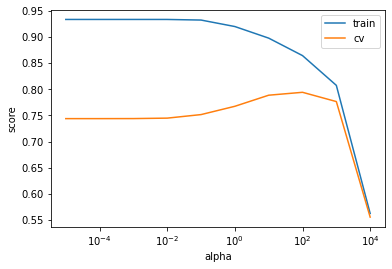

In [36]:
plt.semilogx(alphas, train_scores, label="train");
plt.semilogx(alphas, cv_scores, label="cv");
plt.legend();
plt.xlabel('alpha');
plt.ylabel('score');

In [37]:
best_alpha = alphas[np.argmax(cv_scores)]
best_alpha

100.0

#### 3). `RidgeCV`

BTW, because it's so common to want to tune `alpha` with `Ridge`, sklearn provides a class called `RidgeCV`, which automatically tunes `alpha` based on cross-validation.

In [38]:
ridgecv = make_pipeline(preprocessor, RidgeCV(alphas=alphas))
ridgecv.fit(X_train, y_train);
ridgecv[1].alpha_

100.0

## 3. Scores

- mean squared error (MSE)
- $R^2$
- root mean squared error (RMSE)
- MAPE

<br>


#### Summary of Scoring metrics
- $R^2$ is the default .score(), it is unitless, 0 is bad, 1 is best
- MSE (mean squared error) is in units of target squared, hard to interpret; 0 is best
- RMSE (root mean squared error) is in the same units as the target; 0 is best
- MAPE (mean average percent error) is unitless; 0 is best, 1 is bad

See [sklearn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) for more details. 

In [39]:
lr_tuned = make_pipeline(preprocessor, Ridge(alpha=best_alpha))
lr_tuned.fit(X_train, y_train);

#### 1). mean squared error (MSE)

The error is big because 
- Unlike classification, with regression our target has units.
- The target is in dollars, the mean squared error is in $dollars^2$ 
- The score also depends on the scale of the targets. 
- If we were working in cents instead of dollars, our MSE would be $10,000 \times (100^2$) higher!

In [40]:
from sklearn.metrics import mean_squared_error 
preds = lr_tuned.predict(X_train)
mean_squared_error(y_train, preds)

865443401.107243

#### 2). R squared


- $R^2$ is the score that `sklearn` uses by default when you call score():
- You can [read about it](https://en.wikipedia.org/wiki/Coefficient_of_determination) if interested.
- Intuition: mean squared error, but flipped (higher is better), and **normalized so the max is 1**.
- MSE is "reversible" but $R^2$ is not: (sklearn uses `r2_score(y_train, preds)`)

    ```python
    `mean_squared_error(y_train, preds)` == `mean_squared_error(preds, y_train)`
    `r2_score(y_train, preds)` != `r2_score(preds, y_train)`
    ```

Key points:
- The maximum is **1 for perfect predictions**
- **Negative values are very bad**: "worse than DummyRegressor" (very bad)

In [41]:
r2_score(y_train, preds)

0.8613686047507993

#### 3). Root mean squared error or RMSE

- The MSE above is in $dollars^2$.
- A more relatable metric would be the root mean squared error, or RMSE

In [42]:
np.sqrt(mean_squared_error(y_train, preds))

29418.41941891581

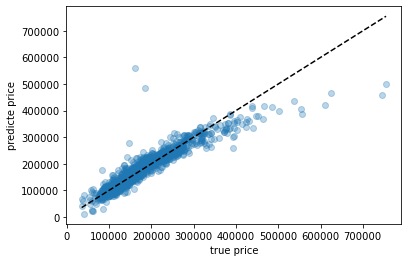

In [43]:
plt.scatter(y_train, lr_tuned.predict(X_train), alpha=0.3)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, '--k');
plt.xlabel("true price");
plt.ylabel("predicte price");

#### 4). MAPE

> mean absolute percent error (MAPE)

In [44]:
def mape(true, pred):
    return 100.*np.mean(np.abs((pred - true)/true))

# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape)

In [45]:
pred_train = lr_tuned.predict(X_train)

# On average, we have around 10% error.
mape(y_train, pred_train) # == mape_scorer(lr_tuned, X_train, y_train) 

10.12358979516996

- In `sklearn` you will notice that it has negative version of the metrics above (e.g., `neg_mean_squared_error`, `neg_root_mean_squared_error`). 
- The reason for this is that scores return a value to maximize, the higher the better.
- If you define your own scorer function and if you do not want this interpretation, you can set the `greater_is_better` parameter to False 

#### 5). all scores at once

In [46]:
scoring={
    "r2": "r2",
    "mape_scorer": mape_scorer,
    "neg_root_mean_square_error": "neg_root_mean_squared_error",    
    "neg_mean_squared_error": "neg_mean_squared_error",    
}

pd.DataFrame(cross_validate(
    lr_tuned, X_train, y_train, return_train_score=True, scoring=scoring
)).T

,0,1,2,3,4
fit_time,4.703808e-02,5.438638e-02,5.436492e-02,5.424690e-02,5.690217e-02
score_time,1.461411e-02,1.997685e-02,1.947522e-02,1.735234e-02,2.630997e-02
test_r2,8.643530e-01,8.225613e-01,8.252302e-01,8.519350e-01,6.076025e-01
train_r2,8.569850e-01,8.637095e-01,8.597770e-01,8.573454e-01,8.846844e-01
test_mape_scorer,9.782268e+00,1.084671e+01,1.192049e+01,1.088294e+01,1.216931e+01
train_mape_scorer,1.040931e+01,1.004660e+01,1.015055e+01,1.028046e+01,9.711958e+00
test_neg_root_mean_square_error,-2.682404e+04,-3.496458e+04,-3.364257e+04,-3.125678e+04,-4.783257e+04
train_neg_root_mean_square_error,-3.043578e+04,-2.874507e+04,-2.941386e+04,-2.962563e+04,-2.704821e+04
test_neg_mean_squared_error,-7.195290e+08,-1.222522e+09,-1.131822e+09,-9.769864e+08,-2.287955e+09
train_neg_mean_squared_error,-9.263368e+08,-8.262792e+08,-8.651749e+08,-8.776780e+08,-7.316056e+08


## 4. Practice questions

> **1. Price per square foot would be a good feature to add in our `X`.**

**Answer:** False, incorporate targets in features. 

> **2. `sklearn's` `LinearRegression` behaves erratically if we're not careful.`.**

**Answer:** True

> **3. The `alpha` hyperparameter of `Ridge` has similar interpretation of `C` hyperparameter of `LogisticRegression`; higher `alpha` means more complex model.**

**Answer:** False, lower alpha -> complex model -> overfitting 

> **4. With `Ridge`, larger values of `alpha` are probably more useful when there are lots of features. (Not sure if we covered this enough for you to answer, but I'm leaving it here anyway.)**

**Answer:** True: hedge
- large alpha -> less complex
- More features -> more complex 

> **5. In regression, one should use MAPE instead of MSE when relative (percent) error matters more than absolute error.**

**Answer:** True

# Lecture 3: Non-linear regression, RBFs, feature engineering 

## 1. Summary

- **Feature engineering** is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.

- Better features usually help more than a better model.
- Good features would ideally:
    - capture most important aspects of the problem
    - allow learning with few examples 
    - generalize to new scenarios.

- There is a trade-off between simple and expressive features:
    - With **simple features** overfitting risk is low, but scores might be low.
    - With **complicated features** scores can be high, but so is overfitting risk.
    
<br> 

#### The best features may be dependent on the model you use.

- Examples:
    - For counting-based methods like naive Bayes and decision trees separate relevant groups of variable values
        - Discretization makes sense 
    - For distance-based methods like KNN, we want different class labels to be "far".
        - Standardization 
    - For regression-based methods like linear regression, we want targets to have a linear dependency on features.
        - Non-linear (e.g., polynomial) transformations        

## 2. Polynomial feature transformations for non-linear regression

- Interested in predicting a scalar valued target (e.g., stock price)
- $\hat{y}$ is the linear function of features $x$ and weights $w$. 

$$\hat{y} = w^Tx + b$$
        
- $\hat{y} \rightarrow$ prediction
- $w \rightarrow$ weight vector
- $b \rightarrow$ bias
- $x \rightarrow$ feature vector
- $w$ and $b$ together are the parameters

$$\hat{y} = \begin{bmatrix}w_1 & w_2 & \cdots & w_d\end{bmatrix}\begin{bmatrix}x_1 \\ x_2 \\ \vdots \\ x_d\end{bmatrix} + b$$

#### 1). Bias term


$$ f(w) = \frac{1}{2}\sum_i^{n}{(w^Tx_i - y_i)^2}$$

- Why don't we have a bias term (i.e., a y-intercept)?
  - For simplicity, we renameabias term as w_0 and introduce a dummy feature $x_0$ whose value is always 1. 
  - So $w_0 + w_1x_1 + \dots + w_nx_n$ becomes $w_0x_0 + w_1x_1 + \dots + w_nx_n$, where $x_0$ is always 1. 
  
  
  
- Example
    - Suppose $X$ has only one feature, say $x_1$: 
    $$X = \begin{bmatrix}0.86 \\ 0.02 \\ -0.42 \end{bmatrix}$$ 
    - Make a new matrix $Z$ with an extra feature (say $x_0$) whose value is always 1. 
    $$Z = \begin{bmatrix}1 & 0.86\\ 1 & 0.02 \\ 1 & -0.42\\ \end{bmatrix}$$
    - Our $Z$ will have three features $x_0$, $x_1$, $x_1^2$ with polynomial with degree 2. 
$$Z = \begin{bmatrix}1 & 0.86 & 0.74\\ 1 & 0.02 & 0.0004\\ 1 & -0.42 & 0.18\\ \end{bmatrix}$$
    - Use $Z$ instead of $X$ in linear regression. 
    - $Z$ $\rightarrow$ augmented dataset with quadratic features
    - `fit`: We fit using $Z$ and learn weights $v$. 
    - `predict`: When we predict, we need to apply the same transformations on the test example and add these features in the test example and predict using learned weights $v$.

    
    
    
**$\hat{y}$ is a linear function of $v$ and $Z$ but a polynomial function of original features $X$.**

#### 2). `PolynomialFeatures`

> Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are $[1, a, b, a^2, ab, b^2]$.


- **degree increases -> prone to overfitting**

<br>

#### Questions to consider

How do we know what degree of polynomial to use?
- Can we plot data and see how does it look like so that we can pick polynomial with the appropriate degree?
    - Plotting cannot take us much further
    - Not possible to visualize high dimensional data
- Can we consider one feature at a time?  
    - Hopeless when features interact with each other
    - There is a possibility to draw misleading conclusions when you are only looking at one feature at a time.
- Hyperparameter optimization
    - Can be potentially very slow. 

##### example 1: non-linear regression

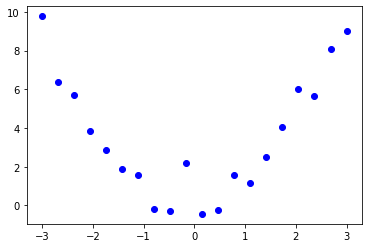

In [47]:
n = 20
X = np.linspace(-3,3,n)
y = X**2 + npr.randn(n)

# transforming the data to include another axis
X = X[:, np.newaxis]
y = y[:, np.newaxis]
plt.scatter(X, y, color='blue')

> transform features

In [48]:
from sklearn.preprocessing import PolynomialFeatures
deg = 2

poly_feats = PolynomialFeatures(degree=deg)
X_enc = poly_feats.fit_transform(X)

pd.DataFrame(X_enc, columns=poly_feats.get_feature_names()).head(10)

,1,x0,x0^2
0,1.0,-3.000000,9.000000
1,1.0,-2.684211,7.204986
2,1.0,-2.368421,5.609418
3,1.0,-2.052632,4.213296
4,1.0,-1.736842,3.016620
5,1.0,-1.421053,2.019391
6,1.0,-1.105263,1.221607
7,1.0,-0.789474,0.623269
8,1.0,-0.473684,0.224377
9,1.0,-0.157895,0.024931


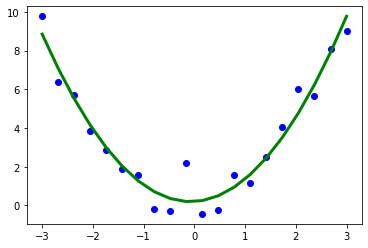

In [49]:
lr_poly = LinearRegression()
lr_poly.fit(X_enc, y)
preds = lr_poly.predict(X_enc)
plt.scatter(X, y, color='blue')
plt.plot(X, preds, color='green', linewidth=3)

In [50]:
deg = 20
poly_feats = PolynomialFeatures(degree=deg)
X_enc = poly_feats.fit_transform(X)
pd.DataFrame(X_enc, columns=poly_feats.get_feature_names()).head(10)

,1,x0,x0^2,x0^3,x0^4,x0^5,x0^6,x0^7,x0^8,x0^9,...,x0^11,x0^12,x0^13,x0^14,x0^15,x0^16,x0^17,x0^18,x0^19,x0^20
0,1.0,-3.000000,9.000000,-27.000000,81.000000,-243.000000,729.000000,-2187.000000,6.561000e+03,-1.968300e+04,...,-1.771470e+05,5.314410e+05,-1.594323e+06,4.782969e+06,-1.434891e+07,4.304672e+07,-1.291402e+08,3.874205e+08,-1.162261e+09,3.486784e+09
1,1.0,-2.684211,7.204986,-19.339700,51.911825,-139.342268,374.023983,-1003.959113,2.694838e+03,-7.233512e+03,...,-5.211735e+04,1.398939e+05,-3.755048e+05,1.007934e+06,-2.705507e+06,7.262150e+06,-1.949314e+07,5.232369e+07,-1.404478e+08,3.769915e+08
2,1.0,-2.368421,5.609418,-13.285464,31.465573,-74.523727,176.503563,-418.034755,9.900823e+02,-2.344932e+03,...,-1.315370e+04,3.115351e+04,-7.378462e+04,1.747531e+05,-4.138888e+05,9.802630e+05,-2.321675e+06,5.498705e+06,-1.302325e+07,3.084454e+07
3,1.0,-2.052632,4.213296,-8.648345,17.751867,-36.438042,74.793875,-153.524271,3.151288e+02,-6.468433e+02,...,-2.725342e+03,5.594124e+03,-1.148268e+04,2.356970e+04,-4.837991e+04,9.930614e+04,-2.038389e+05,4.184062e+05,-8.588338e+05,1.762869e+06
4,1.0,-1.736842,3.016620,-5.239393,9.099999,-15.805262,27.451244,-47.678477,8.280999e+01,-1.438279e+02,...,-4.338741e+02,7.535708e+02,-1.308834e+03,2.273237e+03,-3.948254e+03,6.857494e+03,-1.191038e+04,2.068646e+04,-3.592911e+04,6.240319e+04
5,1.0,-1.421053,2.019391,-2.869660,4.077938,-5.794965,8.234950,-11.702298,1.662958e+01,-2.363151e+01,...,-4.772125e+01,6.781441e+01,-9.636784e+01,1.369438e+02,-1.946043e+02,2.765430e+02,-3.929821e+02,5.584483e+02,-7.935844e+02,1.127725e+03
6,1.0,-1.105263,1.221607,-1.350197,1.492323,-1.649409,1.823031,-2.014930,2.227027e+00,-2.461451e+00,...,-3.006925e+00,3.323444e+00,-3.673280e+00,4.059941e+00,-4.487303e+00,4.959651e+00,-5.481719e+00,6.058742e+00,-6.696505e+00,7.401400e+00
7,1.0,-0.789474,0.623269,-0.492054,0.388464,-0.306682,0.242117,-0.191145,1.509042e-01,-1.191349e-01,...,-7.425304e-02,5.862082e-02,-4.627960e-02,3.653652e-02,-2.884462e-02,2.277207e-02,-1.797795e-02,1.419312e-02,-1.120509e-02,8.846127e-03
8,1.0,-0.473684,0.224377,-0.106284,0.050345,-0.023848,0.011296,-0.005351,2.534611e-03,-1.200605e-03,...,-2.693878e-04,1.276048e-04,-6.044436e-05,2.863154e-05,-1.356231e-05,6.424252e-06,-3.043067e-06,1.441453e-06,-6.827933e-07,3.234284e-07
9,1.0,-0.157895,0.024931,-0.003936,0.000622,-0.000098,0.000015,-0.000002,3.863147e-07,-6.099706e-08,...,-1.520702e-09,2.401109e-10,-3.791224e-11,5.986144e-12,-9.451806e-13,1.492390e-13,-2.356406e-14,3.720641e-15,-5.874696e-16,9.275836e-17


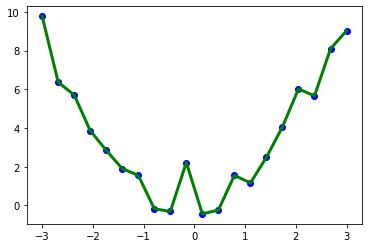

In [51]:
lr_poly = LinearRegression()
lr_poly.fit(X_enc, y)
preds = lr_poly.predict(X_enc)
plt.scatter(X, y, color='blue')
plt.plot(X, preds, color='green', linewidth=3)

##### example 2: Classification setting: Non-linearly separable data

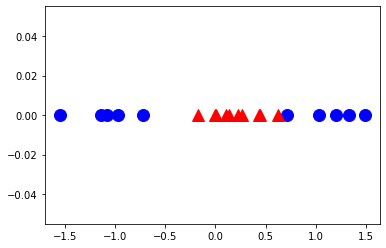

In [52]:
# Consider this one dimensional dataset
n = 20
d = 1
np.random.seed(10)
X = np.random.randn(n,d)
y = np.sum(X**2,axis=1) < 0.4

val = 0. 
plt.plot(X[y==0], np.zeros_like(X[y==0]) + val, 'o', color='blue', linewidth=10, markersize=12)
plt.plot(X[y==1], np.zeros_like(X[y==1]) + val, '^', color='red', linewidth=10, markersize=12)
plt.show()

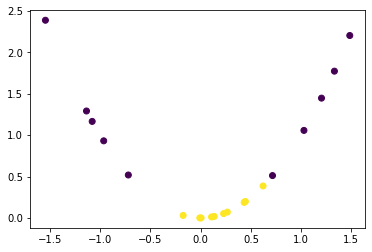

In [53]:
poly = PolynomialFeatures(2, include_bias=False)
X_transformed = poly.fit_transform(X)

plt.scatter(*X_transformed.T, c=y)
plt.show()

Training accuracy 1.0


,0,1
0,10,0
1,0,10


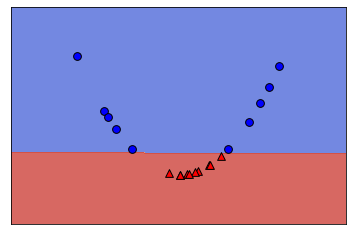

In [54]:
svm = SVC(kernel="linear", C=100)
svm.fit(X_transformed,y)
plot_classifier(X_transformed, y, svm)
print("Training accuracy", svm.score(X_transformed,y))
pd.DataFrame(confusion_matrix(y, svm.predict(X_transformed)))

## 3. Radial Basis Functions (RBF)

#### 1). Problems with polynomial basis 

- <b><font color=Salmon>High order polynomials can become very computationally expensive when there are many features and the order is big.</font></b>
- Let $d$ be the original number of features and $p$ be the degree of polynomial. 
- In general, we have roughly $O(d^p)$ feature combinations. 
    - For example, for $d = 1000$, and $p = 3$, we would have around a billion new feature combinations! 
- This is problematic! 

<center>
<img src='img/compare.png' width="500" />    
</center>

#### 2). How can we do this efficiently? 

- Kernel trick 
    - Computationally efficient approach to map features
    - Calculate these relationships in higher dimensional space without actually carrying out the transformation.
    
    - Overall, saying something is a "kernel method" correspond to this idea of implicitly calculating relationships in data in higher dimensional space.  
    - Then the different transformations have different names like "polynomial kernel" or "RBF kernel"
    - For details see [this video](https://www.youtube.com/watch?v=mba4xweShwI) from CPSC 340. 
   

#### 3). Recall RBF Kernel

- Hard to visualize but you can think of this as a weighted nearest-neighbour.
- During prediction, the closest examples have a lot of influence on how we classify the new example compared to the ones further away.
- In general, for both regression/classification, you can think of RBF kernel as "smooth KNN".
- During test time, each training example gets to "vote" on the label of the test point and the amount of vote the $n^{th}$ training example gets is proportional to the the distance between the test point and itself.  


#### 4). RBF Definition

- Similar to polynomial basis, we transform $X$ to $Z$.
- Consider $X_{train}$ with three examples: $x_1$, $x_2$, and $x_3$ and 2 features and $X_{test}$ with two examples: $\tilde{x_1}$ and $\tilde{x_2}$

$$\text{Transform } X_{train} = \begin{bmatrix} 1 & 0\\ 2 & 1\\ 1 & 2\end{bmatrix} \text{ to } Z_{train} = \begin{bmatrix} g\lVert x_1 - x_1\rVert & g\lVert x_1 - x_2\rVert & g\lVert x_1 - x_3\rVert\\g\lVert x_2 - x_1\rVert & g\lVert x_2 - x_2\rVert & g\lVert x_2 - x_3\rVert\\g\lVert x_3 - x_1\rVert & g\lVert x_3 - x_2\rVert & g\lVert x_3 - x_3\rVert\end{bmatrix}$$  

$$\text{Transform } X_{test} = \begin{bmatrix} 2 & 1\\ 1 & 1 \end{bmatrix} \text{ to } Z_{test} = \begin{bmatrix} g\lVert \tilde{x_1} - x_1\rVert & g\lVert \tilde{x_1} - x_2\rVert & g\lVert \tilde{x_1} - x_3\rVert\\g\lVert \tilde{x_2} - x_1\rVert & g\lVert \tilde{x_2} - x_2\rVert & g\lVert \tilde{x_2} - x_3\rVert\\\end{bmatrix}$$  

- Have $n$ features, with feature $j$ depending on distance to example $i$.


#### 5). Gaussian Radial Basis Functions (Gaussian RBFs)

>  <b><font color=salmon>A kernel is a similarity Function (e.g. Gaussian kernel)</font></b> 

- Most common $g$ is Gaussian RBF: $$g(\varepsilon)=\exp\left(-\frac{\varepsilon^2}{2\sigma^2}\right)$$
- So in our case: 
$$g(x_i - x_j)=\exp\left(-\frac{\lVert x_i - x_j\rVert^2}{2\sigma^2}\right)$$

<center>
<img src='img/RBF.png' width="500" />    
</center>
    

- <b><font color=salmon>$\sigma$ is a hyperparameter that controls the width of the bumps. </font></b> 
- Could then fit least squares with different $\sigma$ values


<br>

#### Gaussian RBFs (non-parametric basis)

<center>
<img src='img/Gaussian_RBF.png' width="500"/>
</center>

- How many bumps should we use?
    - We use $n$ bumps (non-parametric basis)
- Where should the bumps be centered?
    - <b><font color=Salmon>Each bump is centered on one training example $x_i$. </font></b>
- How high should the bumps go?
    - Fitting regression weights $w$ gives us the heights (and signs).
- How wide should the bumps be?
    - The width is a hyper-parameter (<b><font color=LightSeaGreen>smaller $\sigma$ == larger `gamma`-> narrow bumps -> complicated model</font></b>)
- <b><font color=Salmon>Enough bumps can approximate any continuous function to arbitrary precision.</font></b>
- <b><font color=Fuchsia>But with $n$ data points RBFs have $n$ features</font></b>
    - How do we avoid overfitting with this huge number of features?
    - We regularize $w$ (coming up next week) and use validation error to choose $\sigma$ and $\lambda$.
    <center>
    <img src='img/l0.png' width="600"/>
    </center>
    <center>
    <img src='img/l2.png' width="600"/>
    </center>

#### 6). Interpretation of `gamma` in SVM RBF

- `gamma` controls the complexity (fundamental trade-off). 
  - <b><font color=Salmon>larger `gamma` $\rightarrow$ more complex</font></b> 
  - smaller `gamma` $\rightarrow$ less complex
- The `gamma` hyperparameter in SVC is related to $\sigma$ in Gaussian RBF.  
- You can think of `gamma` as the inverse width of the "bumps" 
    - Larger `gamma` means narrower peaks. 
    - Narrower peaks means more complex model. 
    
    
$$g(x_i - x_j)=\exp\left(-\frac{\lVert x_i - x_j\rVert^2}{2\sigma^2}\right)$$  

#### 7). Gaussian RBFs: Prediction 

- Prediction in gaussian RBFs
    
   $$\hat{y_i} = w_1 \exp\left(\frac{-\lVert x_i - x_1\rVert^2}{2\sigma^2}\right) +  w_2 \exp\left(\frac{-\lVert x_i - x_2\rVert^2}{2\sigma^2}\right) + \dots + w_n \exp\left(\frac{-\lVert x_i - x_n\rVert^2}{2\sigma^2}\right)
    = \sum_{j = 1}^n w_j \exp\left(\frac{-\lVert x_i - x_j\rVert^2}{2\sigma^2}\right) $$

- <b><font color=Salmon>Expensive at test time: needs distance to all training examples. </font></b> 

#### 8) RBF with regulariation and optimized $\sigma$ and $\lambda$

- A model that is hard to beat:
    - RBF basis with L2-regularization and cross-validation to choose $\sigma$ and $\lambda$.
    - Flexible non-parametric basis, magic of regularization, and tuning for test error
- For each value of $\lambda$ and $sigma$ 
    - Compute $Z$ on training data
    - Compute best weights $V$ using least squares 
    - Compute $\tilde{Z}$ on validation set (using train set distances)
    - Make predictions $\hat{y} = \tilde{Z}v$
    - Compute validation error 

## 4. Questions

### True/False questions: Non-linear regression (Class discussion)

1. Suppose we add quadratic features to dataset $X$ and the augmented dataset is $Z$. Fitting linear regression on $Z$ would learn a quadratic function of $X$.

> True
<br>

2. The least squares loss function shown below is independent of the bias term (the $y$ intercept).

$$ f(w) = \frac{1}{2}\sum_i^{n}{(w^Tx_i - y_i)^2}$$

> False, the bias term is incorporated in x where we have a new feature called x0 and the new feature value for all examples is 1
<br>

3. If you get the same validation error with polynomials of degrees $d$ and $d+4$, it is a better to pick the polynomial of degree $d$.

> True: when we increase the degree of polynomials, we will have more features which will cause overfitting problem 
<br>

4. With polynomial regression, like with ordinary linear regression, the predictions are a linear function of the weights. 

> true

## 5. Common features used in text classification

#### cons of Bag of words 

- So far for text data we have been using bag of word features. 
- They are good enough for many tasks. But ... 
- This encoding throws out a lot of things we know about language
- It assumes that word order is not that important.   
- So if you want to improve the scores further on text classification tasks you carry out **feature engineering**. 

#### Solutions
- Bag of word features
- N-gram features
- Part-of-speech features
- Classify music style from audio files



#### 1). N-grams 

- A contiguous sequence of _n_ items (characters, tokens) in text.
    <blockquote>
        MDS students are hard-working .
    </blockquote>    

- 2-grams (bigrams): a contiguous sequence of two words
    * _MDS students, students are, are hard-working, hard-working ._
- 3-grams (trigrams): a contiguous sequence of three words
    * _MDS students are, students are hard-working, are hard-working ._

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
X = [
    "URGENT!! As a valued network customer you have been selected to receive a $900 prize reward!",
    "Lol you are always so convincing.",
    "URGENT!! Call right away!!"
]
vec = CountVectorizer(ngram_range=(1,3))
X_counts = vec.fit_transform(X)
bow_df = pd.DataFrame(X_counts.toarray(), columns=vec.get_feature_names(), index=X)
bow_df

,900,900 prize,900 prize reward,always,always so,always so convincing,are,are always,are always so,as,...,urgent call,urgent call right,valued,valued network,valued network customer,you,you are,you are always,you have,you have been
URGENT!! As a valued network customer you have been selected to receive a $900 prize reward!,1,1,1,0,0,0,0,0,0,1,...,0,0,1,1,1,1,0,0,1,1
Lol you are always so convincing.,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,1,1,1,0,0
URGENT!! Call right away!!,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


#### 2). Part-of-speech (POS) in English

- Part-of-speech: A kind of syntactic category that tells you some of the grammatical properties of a word.
    * Noun &rarr; water, sun, cat  
    * Verb &rarr; run, eat, teach

    
<blockquote>
The ____ was running. 
</blockquote>    

- Only a noun fits here. 

In [56]:
sample_text = '''Dolly Parton is a gift to us all. 
From writing all-time great songs like “Jolene” and “I Will Always Love You”, 
to great performances in films like 9 to 5, to helping fund a COVID-19 vaccine, 
she’s given us so much. Now, Netflix bring us Dolly Parton’s Christmas on the Square, 
an original musical that stars Christine Baranski as a Scrooge-like landowner 
who threatens to evict an entire town on Christmas Eve to make room for a new mall. 
Directed and choreographed by the legendary Debbie Allen and counting Jennifer Lewis 
and Parton herself amongst its cast, Christmas on the Square seems like the perfect movie
to save Christmas 2020. 😻 👍🏿'''

In [57]:
import spacy, en_core_web_md
from spacymoji import Emoji


nlp = en_core_web_md.load()

emoji = Emoji(nlp)
nlp.add_pipe(emoji, first=True)

In [58]:
doc = nlp(sample_text)

In [59]:
print([(token, token.pos_) for token in doc][:20])

[(Dolly, 'PROPN'), (Parton, 'PROPN'), (is, 'AUX'), (a, 'DET'), (gift, 'NOUN'), (to, 'ADP'), (us, 'PRON'), (all, 'DET'), (., 'PUNCT'), (
, 'SPACE'), (From, 'ADP'), (writing, 'VERB'), (all, 'DET'), (-, 'PUNCT'), (time, 'NOUN'), (great, 'ADJ'), (songs, 'NOUN'), (like, 'SCONJ'), (“, 'PUNCT'), (Jolene, 'PROPN')]


In [60]:
print("Named entities:\n", [(ent.text, ent.label_) for ent in doc.ents])

Named entities:
 [('Dolly Parton', 'PERSON'), ('Jolene', 'PERSON'), ('I Will Always Love You', 'WORK_OF_ART'), ('9', 'CARDINAL'), ('5', 'CARDINAL'), ('Netflix', 'ORG'), ('Dolly Parton’s', 'PERSON'), ('Christmas', 'DATE'), ('Christine Baranski', 'PERSON'), ('Christmas Eve', 'DATE'), ('Debbie Allen', 'PERSON'), ('Jennifer Lewis \n', 'PERSON'), ('Parton', 'PERSON'), ('Christmas', 'DATE'), ('Christmas 2020', 'DATE')]


In [61]:
doc._.emoji

[('😻', 138, 'smiling cat face with heart-eyes'),
 ('👍🏿', 139, 'thumbs up dark skin tone')]

# Lecture 4: Feature importances and feature selection

> housing data

## 1. Feature correlations

- We can immediately see that `SalePrice` is highly correlated with `OverallQual`.
- This is an early hint that `OverallQual` is a useful feature in predicting `SalePrice`.
- However, this approach is **extremely simplistic**.
  - It only looks at each feature in isolation.
  - It only looks at linear associations:
    - What if `SalePrice` is high when `BsmtFullBath` is 2 or 3, but low when it's 0, 1, or 4? They might seem uncorrelated.

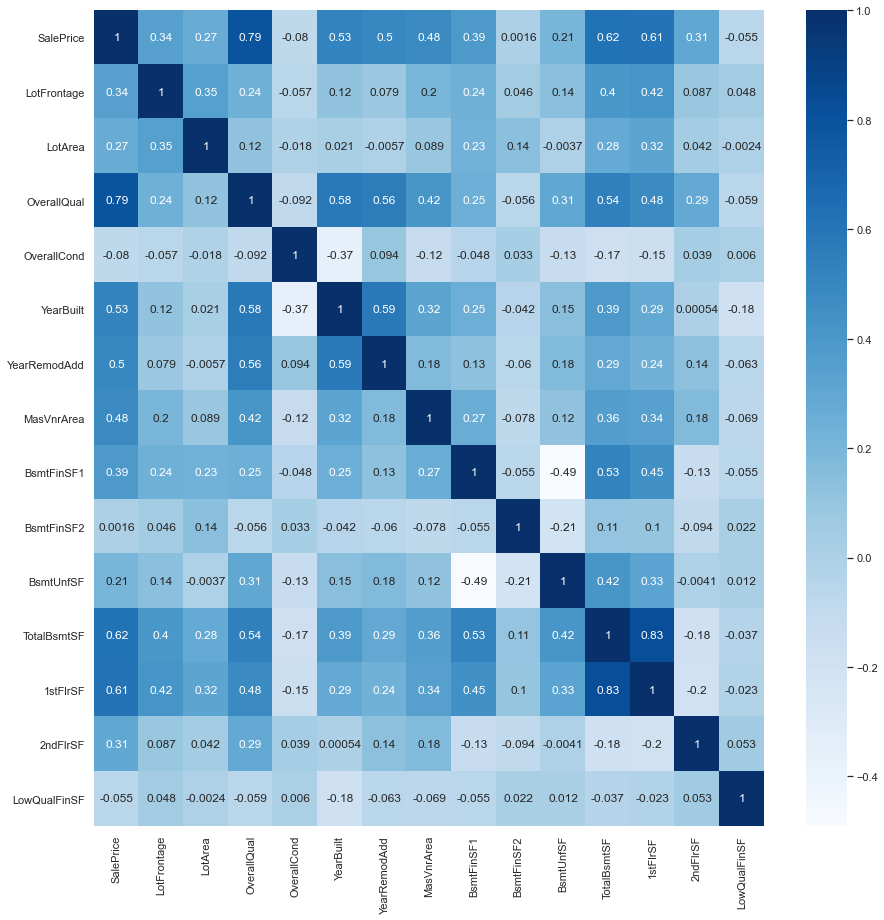

In [66]:
cor = pd.concat((y_train, X_train_enc),axis=1).iloc[:,:15].corr();
plt.figure(figsize=(15,15))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

- Looking at this diagram also tells us the relationship between features. 
  - For example, `1stFlrSF` and `TotalBsmtSF` are highly correlated. 
  - Do we need both of them?
  - If our model says `1stFlrSF` is very important and `TotalBsmtSF` is very unimportant, do we trust those values?
  - Maybe `TotalBsmtSF` only "becomes important" if `1stFlrSF` is removed.
  - Sometimes the opposite happens: a feature only becomes important if another feature is _added_.

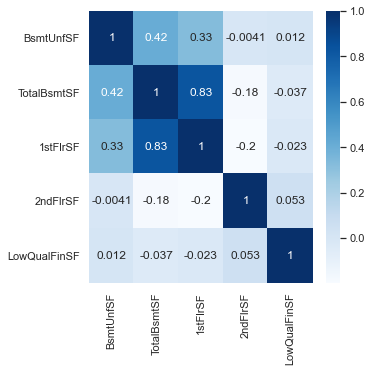

In [67]:
cor = pd.concat((y_train, X_train_enc),axis=1).iloc[:,10:15].corr();
plt.figure(figsize=(5,5))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

## 2. Feature importances in linear models

In [68]:
lr = make_pipeline(preprocessor, Ridge())
lr.fit(X_train, y_train);

#### 1). look at coefficients

In [69]:
lr_coefs = pd.DataFrame(data=lr[1].coef_, index=new_columns, columns=["Coefficient"])
lr_coefs.head(20)

,Coefficient
LotFrontage,-1703.733855
LotArea,5134.590415
OverallQual,12183.566217
OverallCond,4906.516335
YearBuilt,4152.798645
YearRemodAdd,323.657892
MasVnrArea,5238.284880
BsmtFinSF1,3391.272709
BsmtFinSF2,537.817816
BsmtUnfSF,-1420.214114


#### 2). Ordinal features
> "Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by $3845".

In [71]:
print(ordinal_features_reg)

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']


In [72]:
lr_coefs.loc["ExterQual", 'Coefficient']

3845.2197737364418

In [73]:
one_example = X_test[:1]  # one_example['ExterQual'] == Gd
one_example_perturbed = one_example.copy()
one_example_perturbed["ExterQual"] = 'Ex' # Change Gd to Ex


print('Prediction on the original example: ', lr.predict(one_example))
print('Prediction on the perturbed example: ', lr.predict(one_example_perturbed))
print("After changing ExterQual from Gd to Ex increased the prediction by: ", lr.predict(one_example_perturbed) - lr.predict(one_example))

Prediction on the original example:  [221549.8053651]
Prediction on the perturbed example:  [225395.02513883]
After changing ExterQual from Gd to Ex increased the prediction by:  [3845.21977374]


#### 3). Categorical features
>  talk about coef by switching from one of these categories to another by picking a "reference" category:

- If you change the category from `LandSlope_Gtl` to `LandSlope_Mod` the prediction price goes up by $\sim\$7013$
- If you change the category from `LandSlope_Gtl` to `LandSlope_Sev` the prediction price goes down by $\sim\$8016$

In [75]:
lr_coefs_landslope = lr_coefs[lr_coefs.index.str.startswith("LandSlope")]
lr_coefs_landslope - lr_coefs_landslope.loc["LandSlope_Gtl"]

,Coefficient
LandSlope_Gtl,0.000000
LandSlope_Mod,7013.774643
LandSlope_Sev,-8016.922487


#### 4). numeric features
>  <b><font color=Salmon>CAUTION</font></b>
> - relative importance is meaningful after scaling.
> - You have to be careful about the scale of the feature when interpreting the coefficients


<b><font color=Salmon>Wrong Intuition/Interpretation</font></b>
- **Increasing** `PoolArea` by 1 scaled unit **increases** the predicted price by $\sim\$3372$.
- **Increasing** `LotFrontage` by 1 scaled unit **decreases** the predicted price by $\sim\$1703$.


**Does that sound reasonable?**

- For `PoolArea`, yes. 
- For `LotFrontage`, that's surprising. Something positive would have made more sense?
- Do we believe these interpretations??
  - Do we believe this is how the predictions are being computed? Yes.
  - Do we believe that this is how the world works? No. 
  
  
> It's not the case here but maybe the problem is that `LotFrontage` and `LotArea` are very **correlated**. `LotArea` has a larger positive coefficient. 

In [77]:
lr_coefs.loc[["PoolArea", "LotFrontage"]]

,Coefficient
PoolArea,3372.221901
LotFrontage,-1703.733855


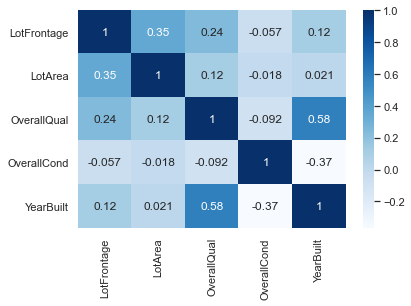

In [79]:
cor = X_train_enc[numeric_features[:5]].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

> In the following experiment 

Why did the prediction only go up by \\$0.57 instead of \\$5134? 
- This is an issue of units. `LotArea` is in sqft, but the coefficient is not $\$5134/\text{sqft}$ **because we scaled the features**. 

In [83]:
one_example = X_test[:1]
one_example_perturbed = one_example.copy()
one_example_perturbed["LotArea"] += 1 # add 1 to the LotArea

diff = lr.predict(one_example_perturbed) - lr.predict(one_example)
LotArea_coef = lr_coefs.loc[["LotArea"]]['Coefficient']


print(f"the difference between prediction: {diff}")

print(f"the coefficient of the feature {LotArea_coef}")

the difference between prediction: [0.57086074]
the coefficient of the feature LotArea    5134.590415
Name: Coefficient, dtype: float64


#### 5). coefficients of scaled features

>  <b><font color=Salmon>We need scaled features because relative feature importances are only meaningful after scaling.</font></b>

In [87]:
scaler = preprocessor.named_transformers_['pipeline-1']['standardscaler']

np.sqrt(scaler.var_)

array([2.09591390e+01, 8.99447103e+03, 1.39208177e+00, 1.11242416e+00,
       3.01866337e+01, 2.06318985e+01, 1.77914527e+02, 4.59101890e+02,
       1.63890010e+02, 4.42869860e+02, 4.42817167e+02, 3.92172897e+02,
       4.35820743e+02, 4.69800920e+01, 5.29468070e+02, 5.18276015e-01,
       2.33809970e-01, 5.49298599e-01, 5.02279069e-01, 1.62604030e+00,
       6.34398801e-01, 2.40531598e+01, 7.40269201e-01, 2.10560601e+02,
       1.25388753e+02, 6.57325181e+01, 6.07432962e+01, 3.03088902e+01,
       5.38336322e+01, 4.23249944e+01, 5.22084645e+02, 1.33231649e+00])

> to explain the situation in 4). 

- It seems like `LotArea` was divided by 8994.471032 sqft. 
- The coefficient tells us that if we increase the `LotArea` by **one unit** the price would go up by $5134.
- **One (scaled) unit** represents 8994 sq feet
- So if I increase original `LotArea` by one square foot then the predicted price would go up by this amount:

```python
5134.590415/8994.471032 
```

In [95]:
lr_coefs.loc[["LotArea"]]

,Coefficient
LotArea,5134.590415


In [96]:
# use scaler.var_
lr_scales = pd.DataFrame(data=np.sqrt(scaler.var_), index=numeric_features, columns=["Scale"])

# use inverse_transform
delta = scaler.inverse_transform(np.ones(len(numeric_features))) - scaler.inverse_transform(np.zeros(len(numeric_features)))
lr_scales = pd.DataFrame(data=delta, index=numeric_features, columns=["Scale"])
lr_scales.head()

,Scale
LotFrontage,20.959139
LotArea,8994.471032
OverallQual,1.392082
OverallCond,1.112424
YearBuilt,30.186634


## 3. Feature selection

> Find the features	(columns) $X$ that are important for predicting	$y$, and remove the features that aren't. 

#### 1). RFE (Recursive feature elimination)

<li><b><font color=salmon>Basic idea</font></b></li>

1. Decide $k$, the number of features to select. 
2. Assign importances to features, e.g. by fitting a model and looking at `coef_` or `feature_importances_`.
3. Remove the least important feature.
4. Repeat steps 2-3 until only $k$ features are remaining.

Note that this is **not** the same as just removing all the less important features in one shot!


<li><b><font color=salmon>RFE VS backward selection</font></b></li>

RFE is based on the coefficients (removing features with lowest coefficients) whereas backward selection is based on scores (e.g., cross-validation scores after removing the feature). So RFE makes its decision based on feature importances (i.e., coefficients given by the model) whereas backward/forward selection don't really look at individual coefficients associated with features.


> `RidgeCV`

In [97]:
results = {}

lr = RidgeCV()
results['RidgeCV'] = pd.DataFrame(cross_validate(lr, X_train_enc, y_train, return_train_score=True)).mean()

In [99]:
lr.fit(X_train_enc, y_train)
coef_df = pd.DataFrame(data=np.abs(lr.coef_), index=X_train_enc.columns, columns=["Coefficients"]).sort_values(by="Coefficients", ascending=False)
coef_df.head(10)

,Coefficients
RoofMatl_ClyTile,30242.974586
Neighborhood_NridgHt,29068.060282
Neighborhood_StoneBr,27000.965529
Neighborhood_NoRidge,24124.358008
Condition2_PosN,23269.883375
RoofMatl_WdShngl,22399.388672
PoolQC,17341.291291
BsmtExposure_Gd,15085.755613
Neighborhood_Edwards,14687.419416
OverallQual,14502.137418


> `RFE` will select the top 30 features, one at a time, based on the absolute value of `model.coef_`:


- **We are violating the Golden Rule a bit here.**    
- Because the transformed data in the training fold would have used information from the validation fold (e.g., in case of scaling).
- The point is that we have already transformed data which we are passing to cross validation. So the training split in each fold would have used information from the examples in the validation split when we applied transformation (e.g., scaling transformation).

In [100]:
from sklearn.feature_selection import RFE, RFECV

rfe = RFE(Ridge(), n_features_to_select=30)

results['RFE with 30 feats'] = pd.DataFrame(cross_validate(rfe, X_train_enc, y_train, return_train_score=True)).mean()
pd.DataFrame(results)

,RidgeCV,RFE with 30 feats
fit_time,0.035105,0.725741
score_time,0.004435,0.003858
test_score,0.791239,0.760755
train_score,0.897700,0.857623


##### RFE selected features

In [104]:
rfe.n_features_

30

In [102]:
rfe.fit(X_train_enc, y_train)
selected_columns = X_train_enc.columns[rfe.support_]
selected_columns

Index(['OverallQual', '1stFlrSF', '2ndFlrSF', 'BsmtQual', 'MSZoning_C (all)',
       'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Roll',
       'RoofMatl_WdShngl', 'BedroomAbvGr_0', 'BedroomAbvGr_1',
       'BedroomAbvGr_5', 'Exterior1st_AsphShn', 'Exterior1st_ImStucc',
       'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_StoneBr',
       'SaleType_Con', 'SaleType_New', 'Condition2_PosN', 'KitchenAbvGr_1',
       'KitchenAbvGr_3', 'SaleCondition_Family', 'BsmtExposure_Gd',
       'Heating_OthW', 'Exterior2nd_ImStucc', 'RoofStyle_Flat'],
      dtype='object')

> - Ranking based on feature importances.
> - Selected features are assigned rank 1.

In [105]:
rfe.ranking_ # may be different than the ranked feature importances!

array([191, 107,   1,  91, 110, 254,  86, 193, 242,  41,  46,   1,   1,
       228,  22, 183, 240, 179, 186, 115, 166, 249,  38, 266, 219, 260,
       257, 210, 195, 155, 258, 245, 135, 172,   1, 227, 251,  19, 236,
       140, 259,  11, 235, 222,   1,   7, 131,  92, 221,   6,  30,  68,
       139, 153, 151,  25,  58, 216,  32,  24, 213,  47, 134,  31,   8,
       133,   1,   1,  17,  44,   1,  45,  26,   1, 268,  78,  79, 205,
       178,  28,  37,  51, 265, 231,  82, 159, 250, 173, 157, 188,  12,
       226, 171, 142,   4, 232, 101, 225, 230, 162, 234, 164,  96, 229,
        50, 233, 167,   1,   1, 214, 104, 114,   1, 112, 149, 127,   1,
       175,  20, 184, 117, 168,   1, 126, 206, 181, 202, 261, 207, 224,
       122, 121, 238, 161, 120, 125, 124, 156,  95, 217, 187,   1,   1,
         1,  90, 143, 198,  15, 247,  77,  72,   2,  62,  66,  67,  61,
        65,  70,  14,  69,   1,   1,  63,  71,  75,  74, 165,   1,  73,
       209,  27,  43,   1,  42, 244,  94,   1, 108,  93,   5,  4

##### `RFECV`

> How to choose the number of features to select

In [106]:
rfe_cv = RFECV(Ridge(), cv=10)
rfe_cv.fit(X_train_enc, y_train)
print('Number of selected features: %d/%d' % (rfe_cv.n_features_, X_train_enc.shape[1]))

Number of selected features: 84/297


> incorporate pipeline

In [108]:
from sklearn.linear_model import RidgeCV

pipe_rfe_ridgecv = make_pipeline(preprocessor, RFECV(Ridge(), cv=10), RidgeCV())

results['pipe RFECV + RidgeCV'] = pd.DataFrame(cross_validate(pipe_rfe_ridgecv, X_train, y_train, return_train_score=True)).mean()

pd.DataFrame(results)

,RidgeCV,RFE with 30 feats,pipe RFECV + RidgeCV
fit_time,0.035105,0.684034,8.231220
score_time,0.004435,0.003446,0.014841
test_score,0.791239,0.760755,0.771576
train_score,0.897700,0.857623,0.884238


In [109]:
pipe_rfe_ridgecv.fit(X_train,y_train)
# print(pipe_rfe_ridgecv.named_steps["rfecv"].support_)
print(
    "The number of features selected by RFE: ",
    pipe_rfe_ridgecv.named_steps["rfecv"].n_features_,
)

The number of features selected by RFE:  84


> get feature names of selected features

In [110]:
feature_names = X_train_enc.columns
support = pipe_rfe_ridgecv.named_steps["rfecv"].support_
RFE_selected_feats = np.array(feature_names)[support]
RFE_selected_feats

array(['OverallQual', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'GarageCars', 'BsmtQual', 'KitchenQual', 'PoolQC',
       'MSZoning_C (all)', 'MSZoning_FV', 'LandContour_Bnk',
       'LandContour_HLS', 'Condition1_Norm', 'Condition1_RRAe',
       'Condition1_RRAn', 'Condition1_RRNn', 'LotShape_IR2',
       'LotShape_IR3', 'RoofMatl_ClyTile', 'RoofMatl_CompShg',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl',
       'Foundation_Wood', 'Street_Grvl', 'Street_Pave', 'Functional_Maj2',
       'Functional_Typ', 'MoSold_10', 'BedroomAbvGr_0', 'BedroomAbvGr_1',
       'BedroomAbvGr_5', 'Exterior1st_AsphShn', 'Exterior1st_BrkFace',
       'Exterior1st_ImStucc', 'MSSubClass_120', 'MSSubClass_160',
       'MSSubClass_180', 'Neighborhood_BrDale', 'Neighborhood_Crawfor',
       'Neighborhood_NPkVill', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_StoneBr', 'SaleType

#### 2). forward selection (Search and score method)


<b><font color=LightSeaGreen>General idea of search and score methods</font></b> 
- Define a **scoring function** $f(S)$ that measures the quality of the set of features $S$. 
- Now **search** for the set of features $S$ with the best score.
- Example: Suppose you have three features: $A, B, C$
    - Compute **score** for $S = \{\}$
    - Compute **score** for $S = \{A\}$
    - Compute **score** for $S= \{B\}$
    - Compute **score** for $S = \{C\}$
    - Compute **score** for $S = \{A,B\}$    
    - Compute **score** for $S = \{A,C\}$
    - Compute **score** for $S = \{B,C\}$
    - Compute **score** for $S = \{A,B,C\}$    
- Return $S$ with the best score.  
- How many distinct combinations we have to try out? 

<b><font color=LightSeaGreen>Problems with search and score methods</font></b> 
 
- If there are $d$ features, there are $2^d$ combinations to search.
    - For example, if $d=100$, we have $1.26 \times 10^{30}$ combinations to search
- Large search space.     
- Optimization bias is high: we are optimizing over $2^d$ models!    
- Irrelevant variables sometimes help by chance. Prone to overfitting.  

How do we deal with these problems? 

- How can we deal with the large search space? 
    - Instead of exhaustively searching for this space, we go with greedy approaches. No guarantee to find optimal feature set.  
- How can we pick a model that's less likely to overfit?     
    - Adding complexity penalty

##### **Forward selection**



<b><font color=LightSeaGreen>1. Properties</font></b>

Not guaranteed to find the best feature set but reduces many problems
    - Cheaper (considers only $O(d^2)$ models compared to $O(2^d)$ models) 
    - Overfits less (less optimization bias) 

<b><font color=LightSeaGreen>2. ideas</font></b>
  
Given $X = \{x_1, x_2, \dots, x_n\}$ and $y$
1. Start with an empty set of features $S = \{\}$ 
2. Initialize the score (e.g., score = $\infty$, if score is validation error)
3. For each possible feature $x_j, 1\leq j \leq n$ 
    - Compute the scores of features in $S$ combined with $x_j$
4. If no $x_j$ improves the score, stop. 
5. Otherwise add feature $x_j$ to $S$ which improves the score the most, update the score, and go back to step 2. 


<center>
    <img src='img/forward_selection.png' width="600" />
</center>




In [111]:
from mlxtend.feature_selection import SequentialFeatureSelector

pipe_forward_ridgecv = make_pipeline(
    preprocessor, 
    SequentialFeatureSelector(Ridge(), forward=True, k_features=20),
    RidgeCV(),
)

scores = cross_validate(pipe_forward_ridgecv, X_train, y_train, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       45.789598
score_time      0.013857
test_score      0.783136
train_score     0.865380
dtype: float64

> names of selected features

In [112]:
pipe_forward_ridgecv.fit(X_train, y_train)

feature_names = X_train_enc.columns
fs_selected_feats = [feature_names[i] for i in pipe_forward_ridgecv.named_steps["sequentialfeatureselector"].k_feature_idx_]
fs_selected_feats

['LotArea',
 'OverallQual',
 'OverallCond',
 'GrLivArea',
 'GarageCars',
 'BsmtQual',
 'KitchenQual',
 'LandContour_Bnk',
 'Condition1_Norm',
 'BsmtFinType1_Unf',
 'MSSubClass_20',
 'Neighborhood_Crawfor',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'SaleType_New',
 'GarageFinish_Fin',
 'BldgType_1Fam',
 'BsmtExposure_Gd']

#### 3). Scoring using $L0$ "norm" 


- Most common "scores" have the form.

$$ score(S) = \frac{1}{2}\lVert{Xw -y}\rVert^2 + \lambda \lVert w\rVert_0$$

- $\lambda \rightarrow \text{penalization factor (strength of penalty) }$

- $ \lVert w\rVert_0 \rightarrow$ Number of non-zero elements in $w$ (i.e., number of features used)
- To increase the degrees of freedom by one, need to decrease the error by $\lambda$. 
- <b><font color=salmon>Prefer smaller degrees of freedom if errors are similar. </font></b>
- Can't optimize because the function is discontinuous in $\lVert w\rVert_0$
    - Search over possible models 
    
    
#### $L0$ "norm"  and the number of features used

- In linear models, setting $w_j = 0$ is the same as removing the feature.
- Example: $$\hat{y_i} = w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4$$
- $L0$ "norm" is the number of non-zero values.  
- If $w = \begin{bmatrix}0.8 \\ 0.0 \\ 0.03 \\0.1\end{bmatrix}$, $\lVert w\rVert_0 = 3$ and if $w = \begin{bmatrix}0.0 \\ 0.0 \\ 0.22 \\0.0\end{bmatrix}$, $\lVert w\rVert_0 = 1$


## 4. Questions

1. Simple association-based feature selection approaches do not take into account the interaction between features.<br>

> True. we don't take into account interactions between features. Because we simply look at one feature at a time and see how it's related to the target. But when we use `RFE`,  we train ML model before eliminating a feature, and therefore in that case, we take into account the interaction between features. 

2. You can carry out feature selection using linear models by pruning the features which have very small weights (i.e., coefficients less than a threshold).<br>

> True: this is what we do in RFE

3. Forward search is guaranteed to find the best feature set.<br>  

> False, search space is large. We use greedy approach to search.

4. A scoring function in score and search methods can be written as follows. $$ score(S) = \frac{1}{2}\lVert{Xw -y}\rVert^2 + \lambda \lVert w\rVert_0$$
Here smaller $\lVert w\rVert_0$ means we discard most of the features. 

> True: L0 penalty. $\lVert w\rVert_0$ is the number of non-zero elements in $w$.

5. In the above equation, larger $\lambda$ means aggressive feature pruning. 

> True

6. The order of features removed given by `rfe.ranking_` is the same as the order of original feature importances given by a regression model. 

> False: 

# DSCI 573 - Quiz 1 practice questions. 

Note that these are just sample questions for you to get an idea about what to expect in the quiz. They are neither meant to cover all the topics we have covered in the last four lectures nor meant to be indicative of the number of questions in the actual quiz.

### Question 1
Suppose a search engine returns 20 pages, 10 of which were relevant while failing to return 90 additional relevant pages. What are the  precision and recall of this system? 

#### Solution 
$P = \frac{10}{20}$, $R = \frac{10}{100}$


### Question 2

- Consider the dataset below, which has $4$ training examples and $1$ feature:
$$
X = \begin{bmatrix}3 \\4 \\  2 \\ 1 \end{bmatrix}, \quad y = \begin{bmatrix}1\\-0.4\\-0.2\\-0.1\end{bmatrix}.
$$ 

Suppose we want to fit a degree $p=2$ polynomial to this dataset. Write a feature matrix $Z$ that we could use in a linear regression model to fit such a quadratic model. 

##### Solution

$$
{
Z = \begin{bmatrix}1 & 3 & 9\\ 1 & 4 & 16\\ 1 & 2 & 4\\1 & 1 & 1\end{bmatrix}.
}$$

### Question 3
When we do regression with a polynomial basis, how does the degree of the polynomial $p$ affect the two parts of the fundamental trade-off? (Answer in 1 sentence.)

#### Solution
As $p$ goes up, the training error goes down and approximation error goes up. (overfitting)

### Question 4
Suppose someone proposes to select features by fitting a linear regression model, and choosing the features with the largest regression weights. What is a scenario where this would not be effective at selecting relevant features? (Answer in 1 to 2 sentences.)

#### Solution
Anything collinear (or even close to collinear). Other answers are possible, like if the relationship isn't linear.

### Question 5
Why do we use forward selection instead of exhaustively searching all subsets in search and score methods? (Answer in 1 to 2 sentences.)

#### Solution
- It's too expensive to try all subsets. 
- Alternately, forward selection is less prone to false positives.     
    In exhaustive search and score methods, optimization bias is high: we’re optimizing over 2^d models and that's why it's prone to false positives: irrelevant variables will sometimes help by chance.

### Question 6
State whether True or False. 

Assume the following scoring function for search and score methods used with linear models. 
$$ score(S) = \frac{1}{2}\lVert{Xw -y}\rVert^2 + \lambda \lVert w\rVert_0$$

1. Smaller $\lVert w\rVert_0$ means we are discarding most of the features. 
2. $\lambda = 0$ means we are not selecting any of the features. 

#### Solution
1. True 
2. False. λ = 0 means no complexity penalty and it means we are selecting all of the features. 

### Question 7
Why ngram features might be better in some contexts compared to bag-of-word features? (Answer in 1 to 3 sentences.)

#### Solution
Bag-of-word features throw out everything we know about language. Each word is considered independent of its context and its location in text. Ngram features help incorporate context in the input representation. 